# Importing Module and define directories

In [136]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split, StandardScaler, MinMaxScaler

In [251]:

def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    netw.predict(input_data)


# Train - Validation Split

In [252]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
#raw_data=np.delete(raw_data,10,axis=1)
np.random.shuffle(raw_data)
#raw_normalizer=Normalize()
#raw_data=raw_normalizer.normalize(raw_data)

data = raw_data[:,:10] ; labels = raw_data[:,-2:]
normdata=StandardScaler()
normlabel=StandardScaler()
#data=normdata.fit_transform(data)
#labels=normlabel.fit_transform(labels)

In [253]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

In [254]:
structure=[5,5,2]
print(structure)
act_func=[("sigmoid",1),("sigmoid",1),("linear",1)]

start=xavier(structure)

netw = MLP(structure, func=act_func,
           starting_points=start)

[5, 5, 2]


## Train the model

In [255]:
rho = 0 ; eta_0 = 1e-3 ; eta_stop = 0.0001 ; delta=1e-7
kind="eta_decay"
def eta_function(eta_start, eta_decay, # Mandatory parameters
                 train_MEE=None, val_MEE=None, epoch=None): # Parameters of the training (and of the MLP)
    return eta_start * np.exp(-eta_decay * epoch)
eta_params = [eta_0, rho, 'train_MEE', 'val_MEE', 'epoch'] # Pass in list like that:
# First the mandatory parameters and then the attribute of the class to extract

In [256]:
N_epoch = 10000 ; k = 1 ; min_index = 0 ; list_cand = [] ;Mse_cand = [] ; lamb= 0
batch_size = 50 #-1 for batch gradient descent 
alpha = 0.1 ; nesterov= False ; beta = 0.8 ; eta_function = 1e-3
tr_kfold = np.array([])
val_kfold = np.array([])
for i in range (0,k):
    #netw = MLP(structure, func=act_func,starting_points = start)
    TR_set, VL_set, TR_lab, VL_lab = split(data,labels,kind="hold_out")
    netw.train(TR_set,TR_lab , VL_set, VL_lab,
            epoch = N_epoch,
            batch_size=batch_size,
            eta = eta_function, eta_params = eta_params, lamb = lamb,alpha=alpha,
            nesterov=nesterov,RMSProp=True,beta=beta,error_threshold = 0, patience = 200)
    tr_kfold = np.append(tr_kfold,netw.train_MEE[-1])
    val_kfold = np.append(val_kfold,netw.val_MEE[-1])
    Mse_cand = np.append(Mse_cand,netw.train_MSE[-1])
    list_cand.append(netw)
min_index = np.argmin(val_kfold)
#print(tr_kfold, val_kfold) 
#calculate the mean on the k-fold
print('val error : ',np.mean(val_kfold) ,'+/-' ,np.std(val_kfold))
print('training error :',np.mean(tr_kfold),'+/-',np.std(tr_kfold))
print('the best result is :' ,val_kfold[min_index])
print('MSE mean :',(np.mean(Mse_cand)))

Epoch 1056:  [train MEE = 1.1479]  [val MEE = 1.1806]                              
Elapsed time: 10.104911088943481 s
val error :  1.18057834576918 +/- 0.0
training error : 1.147921849200557 +/- 0.0
the best result is : 1.18057834576918
MSE mean : 2.105948857565393


# Plot results

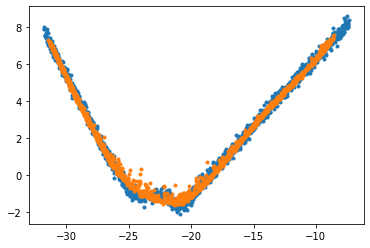

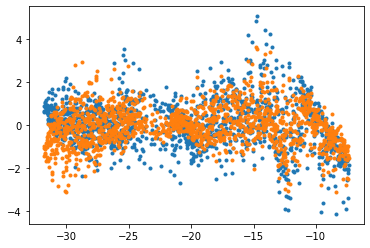

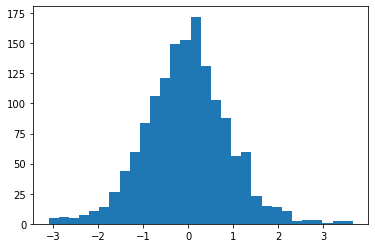

In [257]:
pred=netw.predict(data)
plt.plot(labels[:,1],labels[:,0],".")
plt.plot(pred[:,1],pred[:,0],".")
plt.figure()
plt.plot(np.sort(labels[:,1]),pred[:,1][np.argsort(labels[:,1])]-labels[:,1][np.argsort(labels[:,1])],".")
plt.plot(np.sort(labels[:,1]),pred[:,0][np.argsort(labels[:,1])]-labels[:,0][np.argsort(labels[:,1])],".")
plt.figure()
plt.hist(pred[:,0]-labels[:,0],30)
plt.show()

(array([117., 189., 174., 169., 167., 135., 108.,  90.,  78.,  57.,  36.,
         36.,  24.,  19.,  18.,  18.,  10.,   8.,   4.,   2.,   5.,   1.,
          1.,   4.,   2.,   1.,   2.,   0.,   0.,   2.]),
 array([0.01359381, 0.21955551, 0.4255172 , 0.6314789 , 0.8374406 ,
        1.04340229, 1.24936399, 1.45532568, 1.66128738, 1.86724907,
        2.07321077, 2.27917246, 2.48513416, 2.69109586, 2.89705755,
        3.10301925, 3.30898094, 3.51494264, 3.72090433, 3.92686603,
        4.13282772, 4.33878942, 4.54475112, 4.75071281, 4.95667451,
        5.1626362 , 5.3685979 , 5.57455959, 5.78052129, 5.98648298,
        6.19244468]),
 <BarContainer object of 30 artists>)

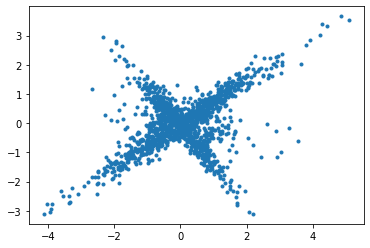

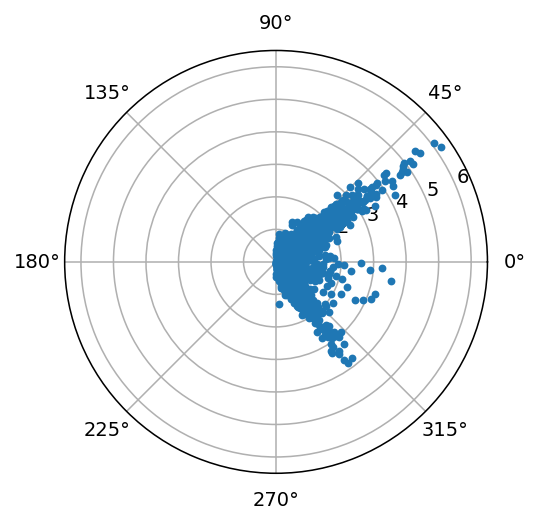

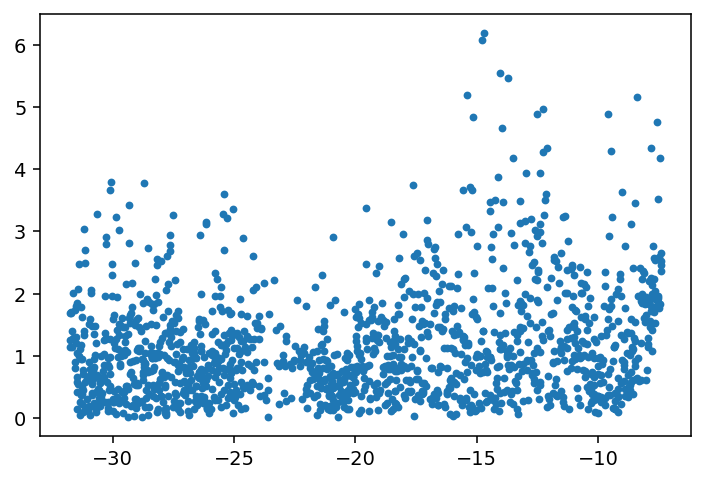

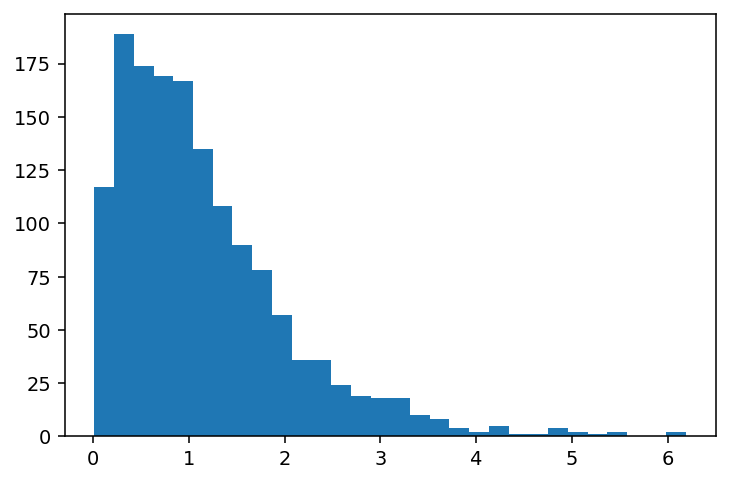

In [258]:
plt.plot(pred[:,1]-labels[:,1],pred[:,0]-labels[:,0],".")
R=np.sqrt((pred[:,0]-labels[:,0])**2+(pred[:,1]-labels[:,1])**2)
theta=np.arctan((pred[:,0]-labels[:,0])/(pred[:,1]-labels[:,1]))
plt.figure(dpi=140)
plt.polar(theta,R,".")
plt.grid
plt.figure(dpi=140)
plt.plot(np.sort(labels[:,1]),R[np.argsort(labels[:,1])],".")
plt.figure(dpi=140)
plt.hist(R,30)

# Keras Try

In [243]:
from keras.layers import Input, Dense
from keras.models import Model
inp=Input(shape=(10,))
hidden=Dense(5,activation='sigmoid')(inp)
hidden=Dense(5,activation='sigmoid')(inp)
output=Dense(2,activation='linear')(hidden)

model=Model(inputs=inp,outputs=output)
model.compile(optimizer='adam',loss='mse')
model.fit(data,labels,epochs=1000,verbose=1)

Epoch 1/1000
47/47 [==============================] - 0s 3ms/step - loss: 229.7962
Epoch 2/1000
47/47 [==============================] - 0s 3ms/step - loss: 224.3809
Epoch 3/1000
47/47 [==============================] - 0s 3ms/step - loss: 219.1896
Epoch 4/1000
47/47 [==============================] - 0s 3ms/step - loss: 214.2469
Epoch 5/1000
47/47 [==============================] - 0s 3ms/step - loss: 209.5195
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 204.9436
Epoch 7/1000
47/47 [==============================] - 0s 3ms/step - loss: 200.5265
Epoch 8/1000
47/47 [==============================] - 0s 3ms/step - loss: 196.2430
Epoch 9/1000
47/47 [==============================] - 0s 3ms/step - loss: 192.0630
Epoch 10/1000
47/47 [==============================] - 0s 3ms/step - loss: 187.9747
Epoch 11/1000
47/47 [==============================] - 0s 3ms/step - loss: 183.9891
Epoch 12/1000
47/47 [==============================] - 0s 3ms/step - loss: 180.0751
E

In [247]:
model.fit(data,labels,epochs=1000,verbose=1)

Epoch 1/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0853
Epoch 2/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0856
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.0861
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.0851
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.0870
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.0867
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.0871
Epoch 8/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0870
Epoch 9/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0861
Epoch 10/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0885
Epoch 11/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0872
Epoch 12/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.0858
Epoch 13/1000
47/47 [====

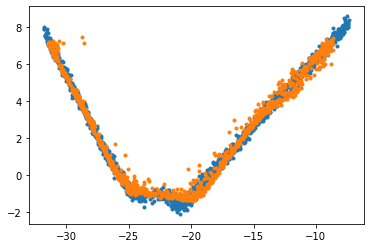

In [248]:
pred=model.predict(VL_set)
tr=model.predict(TR_set)

plt.plot(labels[:,1],labels[:,0],".")
plt.plot(tr[:,1],tr[:,0],".")
#plt.plot(pred[:,1],pred[:,0],".")